<a href="https://colab.research.google.com/github/andresmonsalvo/ML-Sample/blob/main/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐶 Using Transfer Learning and TensorFlow 2.0 to Classify Different Dog Breeds

This notebook uses Tensorflow 2.0 and Tensorflow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog. 

Multi-class image classification is an important problem because it's the same kind of technology Tesla uses in their self-driving cars or Airbnb uses in atuomatically adding information to their listings.

## 2. Data

The data is in Kaggle.

## 3. Evaluation

Using Multi Class Log Loss the evaluation is a file with prediction probabilities for each dog breed of each test image. 

## 4. Features

Some information about the data:

- We are dealing with images (unstructured data) so it's probably best to use deep learning/transfer learning.
- There are 120 breeds of dogs, or 120 different classes.
- There are around 10,000+ images in the training set (with labels)
- There are around 10,000+ images in the test set (without labels)


We are going to go through the following TensorFlow/Deep Learning workflow:

Get data ready (download from Kaggle, store, import).
Prepare the data (preprocessing, the 3 sets, X & y).
Choose and fit/train a model (TensorFlow Hub, tf.keras.applications, TensorBoard, EarlyStopping).
Evaluating a model (making predictions, comparing them with the ground truth labels).
Improve the model through experimentation (start with 1000 images, make sure it works, increase the number of images).
Save, sharing and reloading your model (once you're happy with the results).
For preprocessing our data, we're going to use TensorFlow 2.x. The whole premise here is to get our data into Tensors (arrays of numbers which can be run on GPUs) and then allow a machine learning model to find patterns between them.

For our machine learning model, we're going to be using a pretrained deep learning model from TensorFlow Hub.

The process of using a pretrained model and adapting it to your own problem is called transfer learning. We do this because rather than train our own model from scratch (could be timely and expensive), we leverage the patterns of another model which has been trained to classify images.

In [1]:
# Unzip the uploaded data into Google Drive
# !unzip "drive/My Drive/Dog Vision/dog-breed-identification.zip" -d "drive/My Drive/Dog Vision"

### Get our workspace ready

- Import TensorFlow 2.x ✔
- Import TensorFlow Hub ✔
- Make sure we are using a GPU ✔

In [2]:
# Import necessary tools into Colab
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:",tf.__version__)
print("TF Hub version:",hub.__version__)

# Check for GPU availability
print("GPU", "available (YESSS!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.4.0
TF Hub version: 0.10.0
GPU available (YESSS!!!)


## Getting our data ready (turning into tensors) 

Since the most important step in a deep learning problem is getting the data ready (turning images into tensors, or numerical representation), that's what we're going to start with.

Lets start by accessing our data and checking out the labels.

In [3]:
# Checkout the labels of our data
import pandas as pd
labels_csv=pd.read_csv("drive/My Drive/Dog Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     3f0ef4652899749d98df8a05a576239b  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [4]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


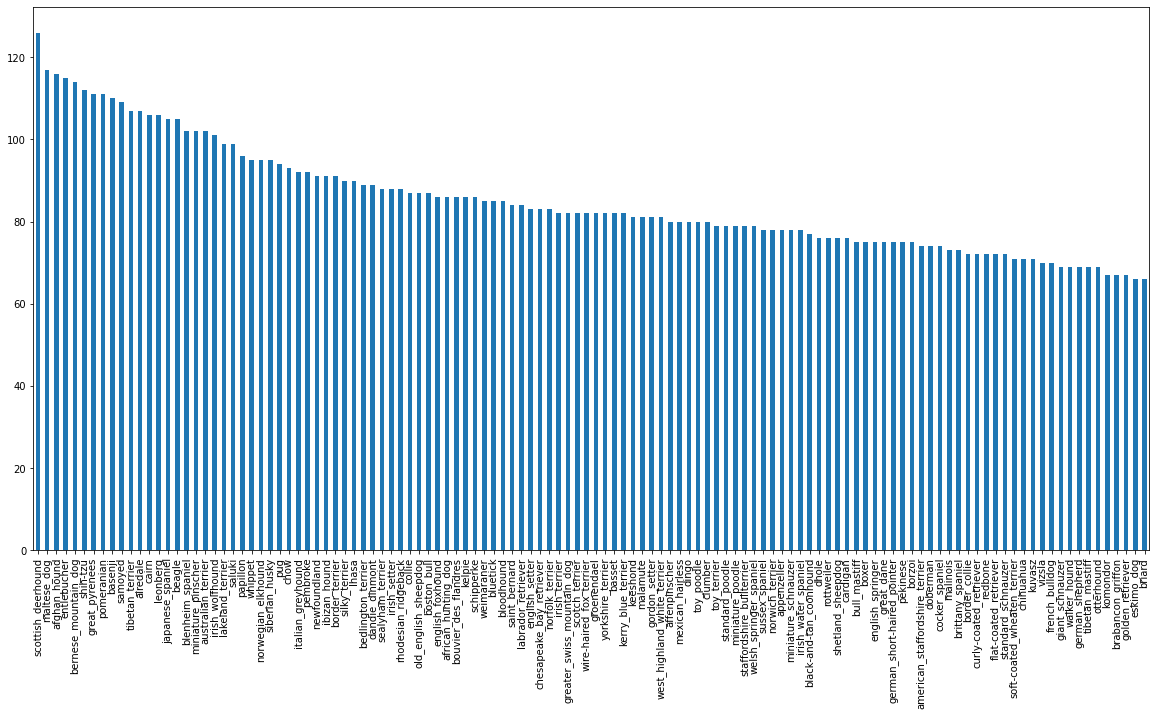

In [5]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10));

Okay sweet. If we were to roughly draw a line across the middle of the graph, we'd see there's about 60+ images for each dog breed.

This is a good amount as for some of their vision products Google recommends a minimum of 10 images per class to get started. And as you might imagine, the more images per class available, the more chance a model has to figure out patterns between them.

Let's check out one of the images.

Note: Loading an image file for the first time may take a while as it gets loaded into the runtime memory. If you see a Google Drive timeout error, check out the Colab FAQ for more.

In [6]:
labels_csv["breed"].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
komondor                 67
brabancon_griffon        67
golden_retriever         67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

In [7]:
labels_csv["breed"].value_counts().median()

82.0

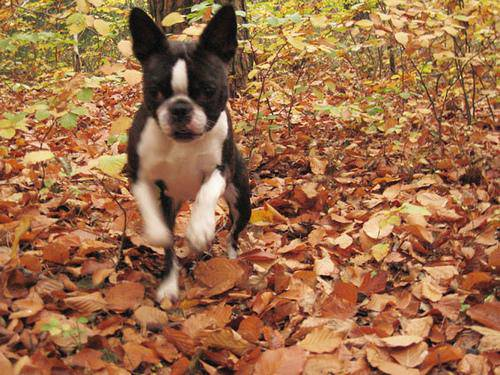

In [8]:
# Viewing an image
from IPython.display import display, Image
Image("drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

### Getting images and their labels

Lets get a list of all of our image file pathnames

In [9]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [10]:
# Create pathnames from image id's
filenames = ["drive/My Drive/Dog Vision/train/"+fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10
filenames[:10]

['drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [11]:
# Ensuring number of filenames above matches number of actual image files in train dataset
import os
if len(os.listdir("drive/My Drive/Dog Vision/train/")) == len(filenames):
  print("Filenames match actual amount of files!")
else:
  print("Filenames do not match actual amount of files, check the target directory.")

Filenames match actual amount of files!


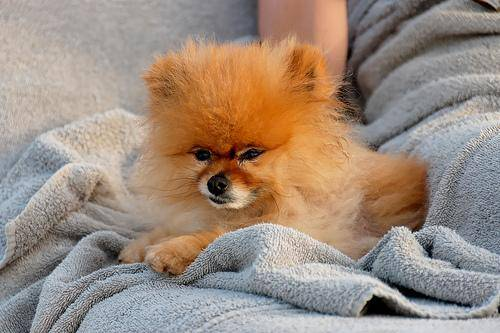

In [12]:
# Check an image directly from a filepath
Image(filenames[8000])

In [13]:
labels_csv["breed"][8000]

'pomeranian'

Now we've got our image filepaths together, let's get the labels.

We'll take them from labels_csv and turn them into a NumPy array.

In [14]:
import numpy as np
labels = labels_csv["breed"].to_numpy() # convert labels column to NumPy array
#labels = np.array(labels) # does same thing as above
labels[:10]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'bedlington_terrier', 'borzoi', 'basenji',
       'scottish_deerhound'], dtype=object)

In [15]:
len(labels)

10222

In [16]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories.")

Number of labels matches number of filenames!


If it all worked, we should have the same amount of images and labels.

Finally, since a machine learning model can't take strings as input (what labels currently is), we'll have to convert our labels to numbers.

To begin with, we'll find all of the unique dog breed names.

Then we'll go through the list of labels and compare them to unique breeds and create a list of booleans indicating which one is the real label (True) and which ones aren't (False).

In [17]:
# Find the unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [18]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [19]:
# Example: Turn one label into an array of booleans
print(labels[0])
labels[0] == unique_breeds # use comparison operator to create boolean array

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [20]:
# Turn every label into a boolean array
boolean_labels = [label == np.array(unique_breeds) for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

Why do it like this?

Remember, an important concept in machine learning is converting your data to numbers before passing it to a machine learning model.

In this case, we've transformed a single dog breed name such as boston_bull into a one-hot array.

Let's see an example.

In [21]:
# Example: Turning a boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])[0][0]) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
19
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


Wonderful! Now we've got our labels in a numeric format and our image filepaths easily accessible (they aren't numeric yet), let's split our data up.

In [22]:
print(labels[2]) # original label
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set

Since the dataset from Kaggle doesn't come with a validation set (a split of the data we can test our model on before making final predicitons on the test set), let's make one.

We could use Scikit-Learn's train_test_split function or we could simply make manual splits of the data.

For accessibility later, let's save our filenames variable to X (data) and our labels to y.

In [23]:
# Setup X & y variables
X = filenames
y = boolean_labels

Since we're working with 10,000+ images, it's a good idea to work with a portion of them to make sure things are working before training on them all.

This is because computing with 10,000+ images could take a fairly long time. And our goal when working through machine learning projects is to reduce the time between experiments.

Let's start experimenting with 1000 and increase it as we need.

In [24]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}
NUM_IMAGES

1000

Now let's split our data into training and validation sets. We'll use and 80/20 split (80% training data, 20% validation data).

In [25]:
# Import train_test_split from Scikit-Learn
from sklearn.model_selection import train_test_split

# Split them into training and validation using NUM_IMAGES 
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES], 
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [26]:
# Check out the training data (image file paths and labels)
X_train[:5], y_train[:2]

(['drive/My Drive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/My Drive/Dog Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/My Drive/Dog Vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/My Drive/Dog Vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, Fa

# Preprocessing images (turning images into Tensors)

Preprocessing images (turning images into Tensors)

Our labels are in numeric format but our images are still just file paths.

Since we're using TensorFlow, our data has to be in the form of Tensors.

A Tensor is a way to represent information in numbers. If you're familar with NumPy arrays (you should be), a Tensor can be thought of as a combination of NumPy arrays, except with the special ability to be used on a GPU.

Because of how TensorFlow stores information (in Tensors), it allows machine learning and deep learning models to be run on GPUs (generally faster at numerical computing).

To preprocess our images into Tensors we're going to write a function which does a few things:

1. Takes an image filename as input.
2. Use TensorFlow to read the file and save it to a variable, image.
3. Turn our image (a jpeg file) into Tensors.
4. Normalize image converting color channel values from 0-255 to 0-1.
5. Resize the image to be of shape (224, 224).
6. Return the modified image.

A good place to read about this type of function is the TensorFlow documentation on loading images.

You might be wondering why (224, 224), which is (heigh, width). It's because this is the size of input our model (we'll see this soon) takes, an image which is (224, 224, 3).

What? Where's the 3 from? We're getting ahead of ourselves but that's the number of colour channels per pixel, red, green and blue.

Let's make this a little more concrete.

In [27]:
# Convert image to NumPy array - Importing an image
from matplotlib.pyplot import imread
image = imread(filenames[42]) # read in an image
image.shape

(257, 350, 3)

Notice the shape of image. It's (257, 350, 3). This is height, width, colour channel value.

And you can easily convert it to a Tensor using tf.constant().

In [28]:
# turn image into a tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

In [29]:
# Define image size
IMG_SIZE = 224

def process_image(image_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  # Read in image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size (224, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

### Creating data batches
Wonderful. Now we've got a function to convert our images into Tensors, we'll now build one to turn our data into batches (more specifically, a TensorFlow BatchDataset).

What's a batch?

A batch (also called mini-batch) is a small portion of your data, say 32 (32 is generally the default batch size) images and their labels. In deep learning, instead of finding patterns in an entire dataset at the same time, you often find them one batch at a time.

Let's say you're dealing with 10,000+ images (which we are). Together, these files may take up more memory than your GPU has. Trying to compute on them all would result in an error.

Instead, it's more efficient to create smaller batches of your data and compute on one batch at a time.

TensorFlow is very efficient when your data is in batches of (image, label) Tensors. So we'll build a function to do create those first. We'll take advantage of of process_image function at the same time.

In [30]:
# Create a simple function to return a tuple of tensors (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [31]:
# Demo of the above
(process_image(X[42]),y[42])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

In [32]:
# Demo of the above
(process_image(X[42]),tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a simple function to turn our image file path names and their associated labels into tuples (we can turn these into Tensors next), we'll create a function to make data batches.

Because we'll be dealing with 3 different sets of data (training, validation and test), we'll make sure the function can accomodate for each set.

We'll set a default batch size of 32 because according to Yann Lecun (one of the OG's of deep learning), friends don't let friends train with batch sizes over 32.

In [33]:
# Define the batch size, 32 is a good default
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels
    
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [34]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [35]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))


Look at that! We've got our data in batches, more specifically, they're in Tensor pairs of (images, labels) ready for use on a GPU.

But having our data in batches can be a bit of a hard concept to understand. Let's build a function which helps us visualize what's going on under the hood.

### Visualizing data batches

In [36]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays 25 images from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(15, 15))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn gird lines off
    plt.axis("off")

In [37]:
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>


To make computation efficient, a batch is a tighly wound collection of Tensors.

So to view data in a batch, we've got to unwind it.

We can do so by calling the as_numpy_iterator() method on a data batch.

This will turn our a data batch into something which can be iterated over.

Passing an iterable to next() will return the next item in the iterator.

In our case, next will return a batch of 32 images and label pairs.

Note: Running the cell below and loading images may take a little while.

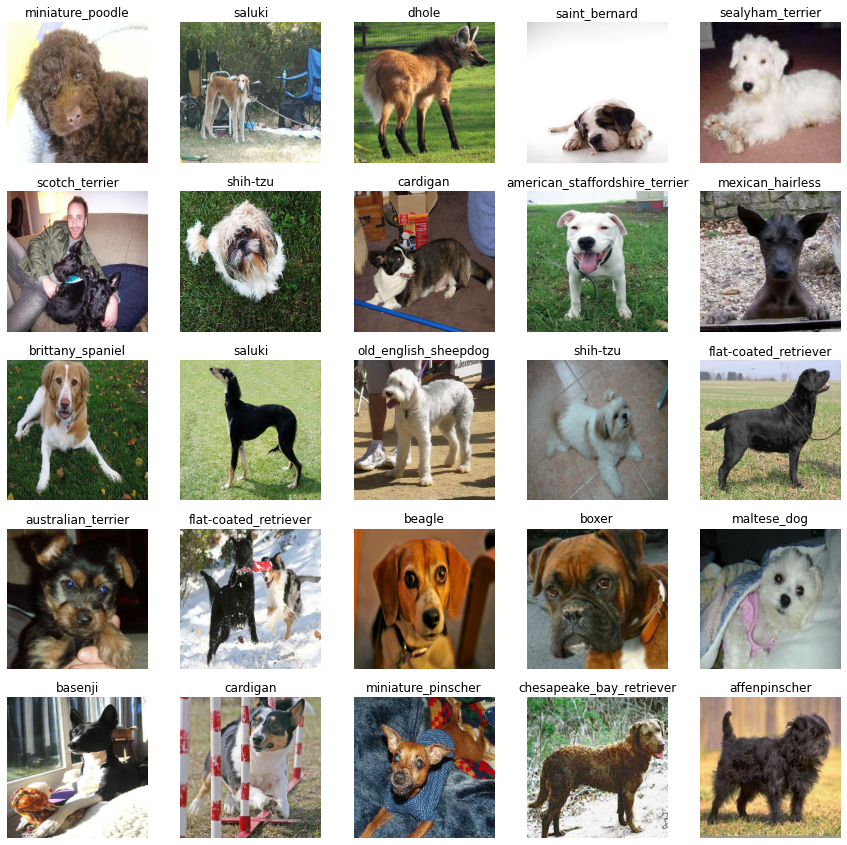

In [38]:
# Visualize training images from the training data batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

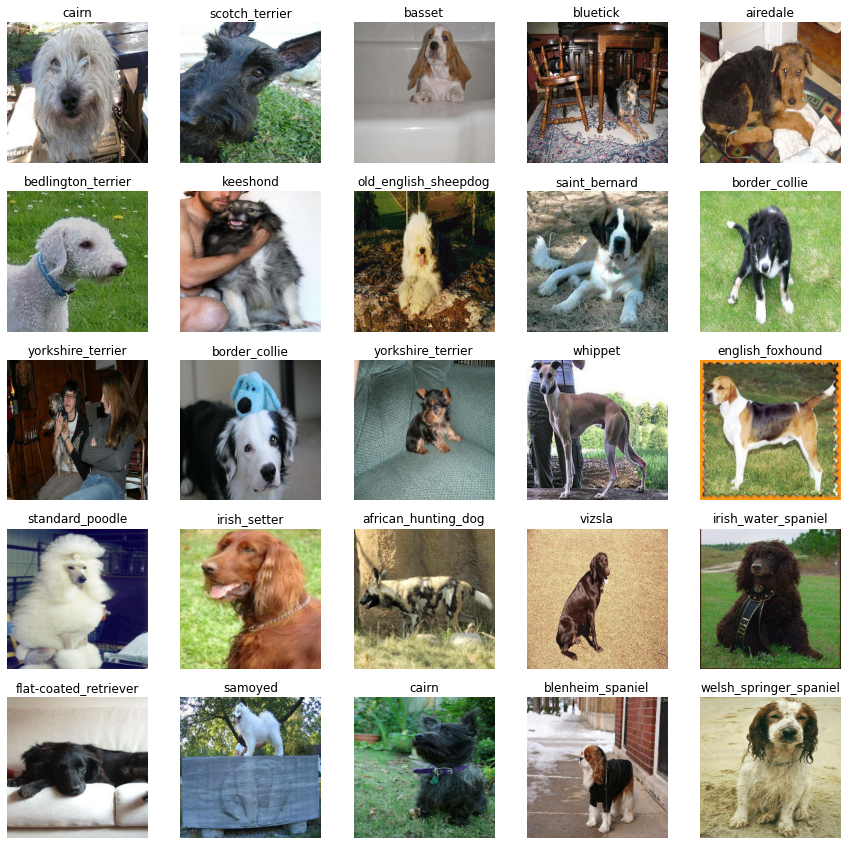

In [39]:
# Visualize validation images from the validation data batch
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

### Creating and training a model
Now our data is ready, let's prepare it modelling. We'll use an existing model from TensorFlow Hub.

TensorFlow Hub is a resource where you can find pretrained machine learning models for the problem you're working on.

Using a pretrained machine learning model is often referred to as transfer learning.

Why use a pretrained model?
Building a machine learning model and training it on lots from scratch can be expensive and time consuming.

Transfer learning helps eliviate some of these by taking what another model has learned and using that information with your own problem.

How do we choose a model?
Since we know our problem is image classification (classifying different dog breeds), we can navigate the TensorFlow Hub page by our problem domain (image).

We start by choosing the image problem domain, and then can filter it down by subdomains, in our case, image classification.

Doing this gives a list of different pretrained models we can apply to our task.

Clicking on one gives us information about the model as well as instructions for using it.

For example, clicking on the mobilenet_v2_130_224 model, tells us this model takes an input of images in the shape 224, 224. It also says the model has been trained in the domain of image classification.

Let's try it out.

### Building a model

Before we build a model, there are a few things we need to define:

The input shape (images, in the form of Tensors) to our model.

The output shape (image labels, in the form of Tensors) of our model.

The URL of the model we want to use.

These things will be standard practice with whatever machine learning model you use. And because we're using TensorFlow, everything will be in the form of Tensors.

In [41]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_breeds) # number of unique labels

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"


Now we've got the inputs, outputs and model we're using ready to go. We can start to put them together

There are many ways of building a model in TensorFlow but one of the best ways to get started is to use the Keras API.

Defining a deep learning model in Keras can be as straightforward as saying, "here are the layers of the model, the input shape and the output shape, let's go!"

Knowing this, let's create a function which:

Takes the input shape, output shape and the model we've chosen's URL as parameters.
Defines the layers in a Keras model in a sequential fashion (do this first, then this, then that).
Compiles the model (says how it should be evaluated and improved).
Builds the model (tells it what kind of input shape it'll be getting).
Returns the model.
We'll take a look at the code first, then dicuss each part.

In [42]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE, 
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(), # Our model wants to reduce this (how wrong its guesses are)
      optimizer=tf.keras.optimizers.Adam(), # A friend telling our model how to improve its guesses
      metrics=["accuracy"] # We'd like this to go up
  )

  # Build the model
  model.build(INPUT_SHAPE) # Let the model know what kind of inputs it'll be getting
  
  return model